In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import string
from torch.utils.data import Dataset
from tqdm import tqdm
import re

class Preprocess:
    def __init__(self,train_file_path,test_file_path,padding=False):
        self.train_file_path=train_file_path
        self.test_file_path=test_file_path
        self.padding=padding
        self.word2idx={"<PAD>":0,"<UNK>":1,"<SOS>":2,"EOS":3}
    
    def process_data(self,split='train',min_cnt=3):
        stop_words = set(stopwords.words('english'))
        punctuations = set(string.punctuation)
        ps = PorterStemmer()
        
        if split=='train':
            file_path = self.train_file_path
        else:
            file_path = self.test_file_path
        data = pd.read_csv(file_path)
        reviews = data['Description']
        print("len of reviews ",len(reviews))
        labels = data['Class Index']
        word_count={}
        cleaned_sentences=[]
        cnt=0;
        for idx, desc in enumerate(reviews):
            curr_record=[]
            curr_record.append("<SOS>")
            for sentence in sent_tokenize(desc):
                sentence = re.sub(r'[\\-]', ' ', sentence)
                sentence = re.sub(r'[^a-zA-Z0-9 ]', '', sentence)
                sentence = word_tokenize(sentence)
                sentence = [word for word in sentence if word not in stop_words]
                for word in sentence:
                    if word not in word_count:
                        word_count[word]=1
                    else:
                        word_count[word]+=1
                curr_record.extend(sentence)
            curr_record.append("<EOS>")
            cleaned_sentences.append(curr_record)
            cnt+=1
            if(cnt==20000):
                break
        if split=='train':
            for word,cnt in word_count.items():
                if(cnt>=min_cnt):
                    self.word2idx[word]=len(self.word2idx)
        for idx,sentence in enumerate(cleaned_sentences):
            cleaned_sentences[idx]=[word if word in self.word2idx else "<UNK>" for word in sentence]
        if split=='train':
            return cleaned_sentences,self.word2idx
        else:
            return cleaned_sentences

In [3]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F

class ElmoDataset(Dataset):
    def __init__(self, X, Y, word2idx, pad=True, max_len=50):
        self.X = X
        self.Y = Y
        self.word2idx = word2idx
        self.pad = pad
        self.max_len = max_len

        # Convert words to indices
        self.X_indexed = []
        for sentence in self.X:
            indexed_sentence = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in sentence]
            self.X_indexed.append(torch.tensor(indexed_sentence))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_forward = self.X_indexed[idx]
        X_backward = X_forward.flip(0)
        if len(X_forward) > self.max_len:
            X_forward = X_forward[:self.max_len]
            X_backward = X_backward[:self.max_len]
        
        # Pad or concatenate sequences
        if self.pad:
            pad_length_forward = max(0, self.max_len - len(X_forward))
            pad_length_backward = max(0, self.max_len - len(X_backward))
            forward = F.pad(X_forward, (0, pad_length_forward))
            backward = F.pad(X_backward, (0, pad_length_backward))
        else:
            forward = X_forward[:self.max_len]
            backward = X_backward[:self.max_len]

        Y = self.Y[idx]
        Y_one_hot = torch.zeros(4)
        Y_one_hot[Y-1] = 1
        return forward, backward, Y_one_hot

In [4]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [5]:
train_path = '/kaggle/input/dataset/train.csv'
test_path = '/kaggle/input/dataset/test.csv'
preprocessor = Preprocess(train_path,test_path)
train_sentences,word2idx=preprocessor.process_data('train')
print(len(train_sentences),len(word2idx))
test_sentences=preprocessor.process_data('test')

len of reviews  120000
20000 15302
len of reviews  7600


In [6]:
df1=pd.read_csv(train_path)
train_Y=df1['Class Index']

df2=pd.read_csv(test_path)
test_Y=df2['Class Index']

train_dataset = ElmoDataset(train_sentences,train_Y,word2idx)

test_dataset = ElmoDataset(test_sentences,test_Y,word2idx)

In [7]:
print(set(train_Y))

{1, 2, 3, 4}


In [8]:
# train_dataset[0]
test_dataset[0]

(tensor([    2, 11467, 10789,  3067, 13590,     1,   929,  6275,   608,  8011,
          9872,    16,  2426,     1,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([    1,     1,  2426,    16,  9872,  8011,   608,  6275,   929,     1,
         13590,  3067, 10789, 11467,     2,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([0., 0., 1., 0.]))

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_sentences, vector_size=150, window=5, min_count=1, workers=4)

word_vectors = model.wv

In [11]:
print(word_vectors.vectors.shape)

(15301, 150)


In [12]:
vector = word_vectors["<UNK>"]
print(vector)

[ 0.02670527 -0.2383838   0.13972011  0.32390067 -0.31606507 -0.56543684
 -0.23780157  0.5127749   0.15798953 -0.0084539   0.05043396  0.1686982
 -0.2836225   0.36255863 -0.3769692  -0.5296956   0.5507053  -0.01179614
 -0.11932799  0.12242425 -0.08133148 -0.09342474 -0.12442802 -0.01935937
  0.4924122  -0.11096561 -0.45808855 -0.0293369  -0.29210007 -0.09852173
  0.07103566 -0.10646214 -0.19034545 -0.62515694 -0.44110516  0.29048762
  0.28456032 -0.78423715  0.31935737 -0.57467425 -0.5652863   0.29796442
 -0.41571587 -0.6965715   0.32869196 -0.12215044 -0.29040673 -0.22534691
  0.6557379   0.33871436 -0.50672287  0.1414918  -0.26087686 -0.14471593
  0.3616706   0.23649931  0.36503503 -0.46806368  0.56454784  0.10122815
  0.15105191 -0.19123314 -0.21092051 -0.16845834  0.44160837  0.07584471
  0.19935153 -0.4016442  -0.37791145 -0.27309376  0.28640753  0.02791175
  0.67048717 -0.35966438  0.00442497  0.10171581 -0.08722004  0.3756359
 -0.3262353   0.02209967  0.01316627 -0.30611467 -0.0

In [13]:
import numpy as np
vocab_size=len(word2idx)
EMBEDDING_DIM=150
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in word2idx.items():
    if(word == '<PAD>'):
        embedding_matrix[idx] = np.zeros(EMBEDDING_DIM)
    else:
        embedding_matrix[idx] = word_vectors[word]
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ELMO(nn.Module):
    def __init__(self, vocab_size, embedding_dim, batch_size, embedding_matrix):
        super(ELMO, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True).to(device)

        self.lstm1 = nn.LSTM(embedding_dim, embedding_dim,
                             batch_first=True, bidirectional=False).to(device)
        self.lstm2 = nn.LSTM(embedding_dim, embedding_dim,
                             batch_first=True, bidirectional=False).to(device)
        
        self.linear1 = nn.Linear(embedding_dim, embedding_dim // 2).to(device)
        self.linear_out = nn.Linear(embedding_dim // 2, vocab_size).to(device)

    def forward(self, X):
        X = self.embedding(X)
        X, _ = self.lstm1(X)
        X, _ = self.lstm2(X)
        X = self.linear1(X)
        linear_out = self.linear_out(X)
        return linear_out

In [15]:
EMBEDDING_DIM=150
VOCAB_SIZE = vocab_size 
BATCH_SIZE=32
forward_model = ELMO(VOCAB_SIZE, EMBEDDING_DIM, BATCH_SIZE, embedding_matrix)
backward_model = ELMO(VOCAB_SIZE, EMBEDDING_DIM, BATCH_SIZE, embedding_matrix)

forward_optimizer = optim.Adam(forward_model.parameters(), lr=0.001)
backward_optimizer = optim.Adam(backward_model.parameters(), lr=0.001)

forward_criterion = nn.CrossEntropyLoss(ignore_index=0)
backward_criterion = nn.CrossEntropyLoss(ignore_index=0)

In [16]:
def train_model(forward_model, backward_model, train_dataloader, forward_optimizer, backward_optimizer, forward_criterion, backward_criterion, epochs):
    best_valid_loss = float('inf')
    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        forward_model.train()
        backward_model.train()
        total_loss = 0
        iter = 0
        for (forward, backward, label) in tqdm(train_dataloader, desc='Training'):
            forward = forward.to(device)
            backward = backward.to(device)
            forward_input_sequence = forward[:, :-1]
            forward_target_sequence = forward[:, 1:]
            backward_input_sequence = backward[:, :-1]
            backward_target_sequence = backward[:, 1:]

            forward_optimizer.zero_grad()
            backward_optimizer.zero_grad()
            forward_output = forward_model(forward_input_sequence)
            backward_output = backward_model(backward_input_sequence)
#             print(forward_output.shape,forward_target_sequence.shape)
            forward_loss = forward_criterion(forward_output.reshape(-1, VOCAB_SIZE), forward_target_sequence.reshape(-1))
#             print(forward_output.reshape(-1, VOCAB_SIZE).shape, forward_target_sequence.reshape(-1).shape)
            backward_loss = backward_criterion(backward_output.reshape(-1, VOCAB_SIZE), backward_target_sequence.reshape(-1))

            forward_loss.backward()
            backward_loss.backward()
            forward_optimizer.step()
            backward_optimizer.step()
            total_loss += forward_loss.item() + backward_loss.item()
            iter += 1
            if iter % 100 == 0:
                print('Iteration: ', iter, 'Train Loss: ', total_loss/iter)
        train_loss = total_loss / len(train_dataloader)
        print('Train Loss: ', train_loss)
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
    
    return losses

In [17]:
epochs=10
train_model(forward_model, backward_model, train_dataloader, forward_optimizer, backward_optimizer, forward_criterion, backward_criterion, epochs)

Epoch:  0


Training:  17%|█▋        | 106/625 [00:04<00:14, 34.62it/s]

Iteration:  100 Train Loss:  16.723633213043215


Training:  33%|███▎      | 206/625 [00:06<00:12, 34.64it/s]

Iteration:  200 Train Loss:  16.32562926054001


Training:  49%|████▉     | 306/625 [00:09<00:09, 34.45it/s]

Iteration:  300 Train Loss:  16.133060094515482


Training:  65%|██████▍   | 406/625 [00:12<00:06, 34.56it/s]

Iteration:  400 Train Loss:  15.992637590169906


Training:  81%|████████  | 506/625 [00:15<00:03, 34.51it/s]

Iteration:  500 Train Loss:  15.871862179756164


Training:  97%|█████████▋| 606/625 [00:18<00:00, 34.34it/s]

Iteration:  600 Train Loss:  15.755750579039256


Training: 100%|██████████| 625/625 [00:19<00:00, 32.74it/s]


Train Loss:  15.729991982269286
Epoch:  1


Training:  17%|█▋        | 104/625 [00:03<00:15, 34.41it/s]

Iteration:  100 Train Loss:  14.865456109046937


Training:  33%|███▎      | 204/625 [00:05<00:12, 34.45it/s]

Iteration:  200 Train Loss:  14.81506756067276


Training:  49%|████▊     | 304/625 [00:08<00:09, 34.23it/s]

Iteration:  300 Train Loss:  14.756701712608338


Training:  65%|██████▍   | 404/625 [00:11<00:06, 34.41it/s]

Iteration:  400 Train Loss:  14.69598396897316


Training:  81%|████████  | 504/625 [00:14<00:03, 34.15it/s]

Iteration:  500 Train Loss:  14.631634145736694


Training:  97%|█████████▋| 604/625 [00:17<00:00, 34.05it/s]

Iteration:  600 Train Loss:  14.585092964172363


Training: 100%|██████████| 625/625 [00:18<00:00, 34.32it/s]


Train Loss:  14.571762851715087
Epoch:  2


Training:  17%|█▋        | 104/625 [00:03<00:15, 34.21it/s]

Iteration:  100 Train Loss:  14.03228799343109


Training:  33%|███▎      | 204/625 [00:05<00:12, 34.25it/s]

Iteration:  200 Train Loss:  14.02581310749054


Training:  49%|████▊     | 304/625 [00:08<00:09, 34.17it/s]

Iteration:  300 Train Loss:  13.994762360254924


Training:  65%|██████▍   | 404/625 [00:11<00:06, 34.17it/s]

Iteration:  400 Train Loss:  13.971621842384339


Training:  81%|████████  | 504/625 [00:14<00:03, 34.12it/s]

Iteration:  500 Train Loss:  13.957646142959595


Training:  97%|█████████▋| 604/625 [00:17<00:00, 33.98it/s]

Iteration:  600 Train Loss:  13.931096921761831


Training: 100%|██████████| 625/625 [00:18<00:00, 34.11it/s]


Train Loss:  13.923702993011474
Epoch:  3


Training:  17%|█▋        | 104/625 [00:03<00:15, 33.78it/s]

Iteration:  100 Train Loss:  13.51520746231079


Training:  33%|███▎      | 204/625 [00:06<00:12, 33.99it/s]

Iteration:  200 Train Loss:  13.55435068845749


Training:  49%|████▊     | 304/625 [00:08<00:09, 33.88it/s]

Iteration:  300 Train Loss:  13.545019931793213


Training:  65%|██████▍   | 404/625 [00:11<00:06, 33.60it/s]

Iteration:  400 Train Loss:  13.535346785783767


Training:  81%|████████  | 504/625 [00:14<00:03, 33.61it/s]

Iteration:  500 Train Loss:  13.523901574134827


Training:  97%|█████████▋| 604/625 [00:17<00:00, 33.28it/s]

Iteration:  600 Train Loss:  13.509474501609802


Training: 100%|██████████| 625/625 [00:18<00:00, 33.67it/s]


Train Loss:  13.509234619903564
Epoch:  4


Training:  17%|█▋        | 104/625 [00:03<00:15, 33.22it/s]

Iteration:  100 Train Loss:  13.163384103775025


Training:  33%|███▎      | 204/625 [00:06<00:12, 33.60it/s]

Iteration:  200 Train Loss:  13.152151610851288


Training:  49%|████▊     | 304/625 [00:09<00:09, 33.20it/s]

Iteration:  300 Train Loss:  13.16405912399292


Training:  65%|██████▍   | 404/625 [00:12<00:06, 33.39it/s]

Iteration:  400 Train Loss:  13.172794686555862


Training:  81%|████████  | 504/625 [00:15<00:03, 33.20it/s]

Iteration:  500 Train Loss:  13.176756844520568


Training:  97%|█████████▋| 604/625 [00:18<00:00, 33.11it/s]

Iteration:  600 Train Loss:  13.179659508069356


Training: 100%|██████████| 625/625 [00:18<00:00, 33.36it/s]


Train Loss:  13.179279359436036
Epoch:  5


Training:  17%|█▋        | 104/625 [00:03<00:15, 32.90it/s]

Iteration:  100 Train Loss:  12.825800132751464


Training:  33%|███▎      | 204/625 [00:06<00:12, 33.03it/s]

Iteration:  200 Train Loss:  12.839000482559204


Training:  49%|████▊     | 304/625 [00:09<00:09, 33.00it/s]

Iteration:  300 Train Loss:  12.872875278790792


Training:  65%|██████▍   | 404/625 [00:12<00:06, 32.95it/s]

Iteration:  400 Train Loss:  12.890391075611115


Training:  81%|████████  | 504/625 [00:15<00:03, 32.91it/s]

Iteration:  500 Train Loss:  12.889419465065002


Training:  97%|█████████▋| 604/625 [00:18<00:00, 32.92it/s]

Iteration:  600 Train Loss:  12.895868410269419


Training: 100%|██████████| 625/625 [00:18<00:00, 32.94it/s]


Train Loss:  12.896235193634034
Epoch:  6


Training:  17%|█▋        | 104/625 [00:03<00:15, 32.73it/s]

Iteration:  100 Train Loss:  12.598878211975098


Training:  33%|███▎      | 204/625 [00:06<00:12, 32.81it/s]

Iteration:  200 Train Loss:  12.637721979618073


Training:  49%|████▊     | 304/625 [00:09<00:09, 32.79it/s]

Iteration:  300 Train Loss:  12.62481218655904


Training:  65%|██████▍   | 404/625 [00:12<00:06, 32.79it/s]

Iteration:  400 Train Loss:  12.638993402719498


Training:  81%|████████  | 504/625 [00:15<00:03, 32.45it/s]

Iteration:  500 Train Loss:  12.655254201889038


Training:  97%|█████████▋| 604/625 [00:18<00:00, 32.57it/s]

Iteration:  600 Train Loss:  12.643601422309876


Training: 100%|██████████| 625/625 [00:19<00:00, 32.66it/s]


Train Loss:  12.64263448638916
Epoch:  7


Training:  17%|█▋        | 104/625 [00:03<00:16, 32.48it/s]

Iteration:  100 Train Loss:  12.304312677383423


Training:  33%|███▎      | 204/625 [00:06<00:13, 32.37it/s]

Iteration:  200 Train Loss:  12.35056935787201


Training:  49%|████▊     | 304/625 [00:09<00:09, 32.35it/s]

Iteration:  300 Train Loss:  12.38411439259847


Training:  65%|██████▍   | 404/625 [00:12<00:06, 32.62it/s]

Iteration:  400 Train Loss:  12.38856384396553


Training:  81%|████████  | 504/625 [00:15<00:03, 32.64it/s]

Iteration:  500 Train Loss:  12.403629259109497


Training:  97%|█████████▋| 604/625 [00:18<00:00, 32.79it/s]

Iteration:  600 Train Loss:  12.417355355421702


Training: 100%|██████████| 625/625 [00:19<00:00, 32.46it/s]


Train Loss:  12.41766304244995
Epoch:  8


Training:  17%|█▋        | 104/625 [00:03<00:15, 32.67it/s]

Iteration:  100 Train Loss:  12.136055598258972


Training:  33%|███▎      | 204/625 [00:06<00:12, 32.93it/s]

Iteration:  200 Train Loss:  12.164134643077851


Training:  49%|████▊     | 304/625 [00:09<00:09, 32.84it/s]

Iteration:  300 Train Loss:  12.180398494402567


Training:  65%|██████▍   | 404/625 [00:12<00:06, 33.01it/s]

Iteration:  400 Train Loss:  12.19196474790573


Training:  81%|████████  | 504/625 [00:15<00:03, 32.68it/s]

Iteration:  500 Train Loss:  12.200626302719117


Training:  97%|█████████▋| 604/625 [00:18<00:00, 32.88it/s]

Iteration:  600 Train Loss:  12.207944104671478


Training: 100%|██████████| 625/625 [00:19<00:00, 32.83it/s]


Train Loss:  12.211902868652343
Epoch:  9


Training:  17%|█▋        | 104/625 [00:03<00:15, 32.88it/s]

Iteration:  100 Train Loss:  11.942597599029542


Training:  33%|███▎      | 204/625 [00:06<00:12, 32.90it/s]

Iteration:  200 Train Loss:  11.970545253753663


Training:  49%|████▊     | 304/625 [00:09<00:09, 32.84it/s]

Iteration:  300 Train Loss:  11.972311811447144


Training:  65%|██████▍   | 404/625 [00:12<00:06, 32.96it/s]

Iteration:  400 Train Loss:  11.984654606580735


Training:  81%|████████  | 504/625 [00:15<00:03, 32.88it/s]

Iteration:  500 Train Loss:  11.998676205635071


Training:  97%|█████████▋| 604/625 [00:18<00:00, 32.88it/s]

Iteration:  600 Train Loss:  12.018129498163859


Training: 100%|██████████| 625/625 [00:19<00:00, 32.88it/s]

Train Loss:  12.020403810882568


{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'train_loss': [15.729991982269286,
  14.571762851715087,
  13.923702993011474,
  13.509234619903564,
  13.179279359436036,
  12.896235193634034,
  12.64263448638916,
  12.41766304244995,
  12.211902868652343,
  12.020403810882568],
 'valid_loss': []}

In [18]:
torch.save(forward_model.state_dict(), '/kaggle/working/forward_model.pt')
torch.save(backward_model.state_dict(), '/kaggle/working/backward_model.pt')

In [19]:
forward_embeddings = list(forward_model.parameters())[0].cpu().detach().numpy()
backward_embeddings = list(backward_model.parameters())[0].cpu().detach().numpy()

print(forward_embeddings.shape,backward_embeddings.shape)

(15302, 150) (15302, 150)


In [20]:
class scoreClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, fw_embeddings, bw_embeddings,
                 forward_lstm1, forward_lstm2, backward_lstm1, backward_lstm2, num_classes, requires_grad=True):
        super(scoreClassifier, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.fw_embeddings = nn.Embedding.from_pretrained(torch.tensor(fw_embeddings, dtype=torch.float).to(device), padding_idx=0)
        self.fw_embeddings.weight.requires_grad = False 

        self.bw_embeddings = nn.Embedding.from_pretrained(torch.tensor(bw_embeddings, dtype=torch.float).to(device), padding_idx=0)
        self.bw_embeddings.weight.requires_grad = True

        self.weights = nn.Parameter(torch.tensor([0.33, 0.33, 0.33], dtype=torch.float).to(device), requires_grad=requires_grad)

        self.forward_lstm1 = forward_lstm1
        self.forward_lstm2 = forward_lstm2
        self.backward_lstm1 = backward_lstm1
        self.backward_lstm2 = backward_lstm2
        self.rnn = nn.LSTM(input_size=2 * embedding_dim, hidden_size=embedding_dim,
                           num_layers=2, batch_first=True, bidirectional=False).to(device)
        self.linear1 = nn.Linear(embedding_dim, embedding_dim//2).to(device)
        self.linear_out = nn.Linear(embedding_dim//2, num_classes).to(device)  
#         self.linear1 = nn.Linear(2 * embedding_dim, embedding_dim).to(device)
#         self.linear_out = nn.Linear(embedding_dim, num_classes).to(device)

    def forward(self, forward, backward):
        fw_embed = self.fw_embeddings(forward)
        bw_embed = self.bw_embeddings(backward)

        fw_lstm1, _ = self.forward_lstm1(fw_embed)
        fw_lstm2, _ = self.forward_lstm2(fw_lstm1)
        bw_lstm1, _ = self.backward_lstm1(bw_embed)
        bw_lstm2, _ = self.backward_lstm2(bw_lstm1)

        embed = torch.cat((fw_embed, bw_embed), dim=2)
        lstm1 = torch.cat((fw_lstm1, bw_lstm1), dim=2)
        lstm2 = torch.cat((fw_lstm2, bw_lstm2), dim=2)

        elmo_out = self.weights[0] * embed + self.weights[1] * lstm1 + self.weights[2] * lstm2
        elmo_max = torch.max(elmo_out, dim=1)[0]
        output,_ = self.rnn(elmo_max)
        output = self.linear1(output)
#         output, _ = self.rnn(output)
        output = self.linear_out(output)
#         lin_out1 = self.linear1(elmo_max)
#         linear_out = self.linear_out(lin_out1)

        return output

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(true_labels,predictions,file_name):
  cm = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.savefig(f'/kaggle/working/{file_name}')
  plt.show()


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_evaluation_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)

    precision = precision_score(true_labels, predictions, average='weighted')
    print("Precision:", precision)

    recall = recall_score(true_labels, predictions, average='weighted')
    print("Recall:", recall)

    f1 = f1_score(true_labels, predictions, average='weighted')
    print("F1 Score:", f1)

In [23]:
def train_classifier(model, train_dataloader, optimizer, criterion, device, epochs=1):
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))
        model.train()
        train_loss = 0
        iter = 0
        total_acc = 0
        true_labels, predictions = [], []
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            batch = tuple(t.to(device) for t in batch)
            forward, backward, labels = batch
            logits = model(forward, backward)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(logits, dim=1)
            train_loss += loss.item()
            iter += 1
            if iter % 100 == 0:
                print("Iteration: {}, Train Loss: {}".format(iter, loss.item()))

In [24]:
def test_model(model, test_loader, criterion, split, file_name):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Ensure the model is on the correct device
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    true_labels, predictions = [], []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, backward, labels in test_loader:
            # Move data to the same device as the model
            inputs = inputs.to(device)
            backward = backward.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs, backward)
            loss = criterion(outputs, labels)

            # Calculate loss
            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_labels = labels.argmax(dim=1)  # Ensure this matches label format
            true_labels.extend(correct_labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            correct_predictions += (predicted == correct_labels).sum().item()

            total_samples += labels.size(0)

    # Compute metrics
    average_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    print(f"{split} Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    print_evaluation_metrics(true_labels, predictions)
    plot_confusion_matrix(true_labels, predictions, f"elmo_with_{file_name}_{split}")

In [25]:
EMBEDDING_DIM=150
VOCAB_SIZE = vocab_size 
BATCH_SIZE=32
num_classes=4
classifier1 = scoreClassifier(VOCAB_SIZE, EMBEDDING_DIM, forward_embeddings,backward_embeddings,
                 forward_model.lstm1, forward_model.lstm2, backward_model.lstm1, backward_model.lstm1, num_classes,requires_grad=False)

print(classifier1)
classifier1.to(device)
optimizer1 = optim.Adam(classifier1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()


scoreClassifier(
  (fw_embeddings): Embedding(15302, 150, padding_idx=0)
  (bw_embeddings): Embedding(15302, 150, padding_idx=0)
  (forward_lstm1): LSTM(150, 150, batch_first=True)
  (forward_lstm2): LSTM(150, 150, batch_first=True)
  (backward_lstm1): LSTM(150, 150, batch_first=True)
  (backward_lstm2): LSTM(150, 150, batch_first=True)
  (rnn): LSTM(300, 150, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=150, out_features=75, bias=True)
  (linear_out): Linear(in_features=75, out_features=4, bias=True)
)


Epoch: 0


Training:  17%|█▋        | 109/625 [00:02<00:08, 59.51it/s]

Iteration: 100, Train Loss: 0.6164835691452026


Training:  33%|███▎      | 207/625 [00:03<00:06, 59.72it/s]

Iteration: 200, Train Loss: 0.5408841371536255


Training:  50%|████▉     | 310/625 [00:05<00:05, 59.50it/s]

Iteration: 300, Train Loss: 0.7942668199539185


Training:  65%|██████▍   | 406/625 [00:07<00:03, 59.18it/s]

Iteration: 400, Train Loss: 0.3790224492549896


Training:  81%|████████▏ | 508/625 [00:08<00:02, 58.34it/s]

Iteration: 500, Train Loss: 0.31283196806907654


Training:  98%|█████████▊| 610/625 [00:10<00:00, 58.96it/s]

Iteration: 600, Train Loss: 0.30963245034217834


Training: 100%|██████████| 625/625 [00:10<00:00, 58.16it/s]


Epoch: 1


Training:  17%|█▋        | 108/625 [00:01<00:08, 59.29it/s]

Iteration: 100, Train Loss: 0.05998045206069946


Training:  34%|███▎      | 210/625 [00:03<00:07, 59.24it/s]

Iteration: 200, Train Loss: 0.2710750102996826


Training:  49%|████▉     | 306/625 [00:05<00:05, 59.10it/s]

Iteration: 300, Train Loss: 0.29142963886260986


Training:  65%|██████▌   | 408/625 [00:06<00:03, 59.33it/s]

Iteration: 400, Train Loss: 0.22104735672473907


Training:  82%|████████▏ | 510/625 [00:08<00:01, 59.07it/s]

Iteration: 500, Train Loss: 0.3487287759780884


Training:  97%|█████████▋| 606/625 [00:10<00:00, 58.61it/s]

Iteration: 600, Train Loss: 0.2788948714733124


Training: 100%|██████████| 625/625 [00:10<00:00, 59.11it/s]


Epoch: 2


Training:  17%|█▋        | 108/625 [00:01<00:08, 59.03it/s]

Iteration: 100, Train Loss: 0.3978283405303955


Training:  34%|███▎      | 210/625 [00:03<00:07, 59.21it/s]

Iteration: 200, Train Loss: 0.20399576425552368


Training:  49%|████▉     | 306/625 [00:05<00:05, 58.91it/s]

Iteration: 300, Train Loss: 0.12257084250450134


Training:  65%|██████▌   | 408/625 [00:06<00:03, 58.92it/s]

Iteration: 400, Train Loss: 0.3783145546913147


Training:  82%|████████▏ | 510/625 [00:08<00:01, 59.19it/s]

Iteration: 500, Train Loss: 0.3229653239250183


Training:  97%|█████████▋| 606/625 [00:10<00:00, 59.23it/s]

Iteration: 600, Train Loss: 0.23881445825099945


Training: 100%|██████████| 625/625 [00:10<00:00, 59.21it/s]


Parameter containing:
tensor([0.3300, 0.3300, 0.3300], device='cuda:0')
train Loss: 0.0938, Accuracy: 0.9735
Accuracy: 0.9735
Precision: 0.9738100233035322
Recall: 0.9735
F1 Score: 0.9735024202554025


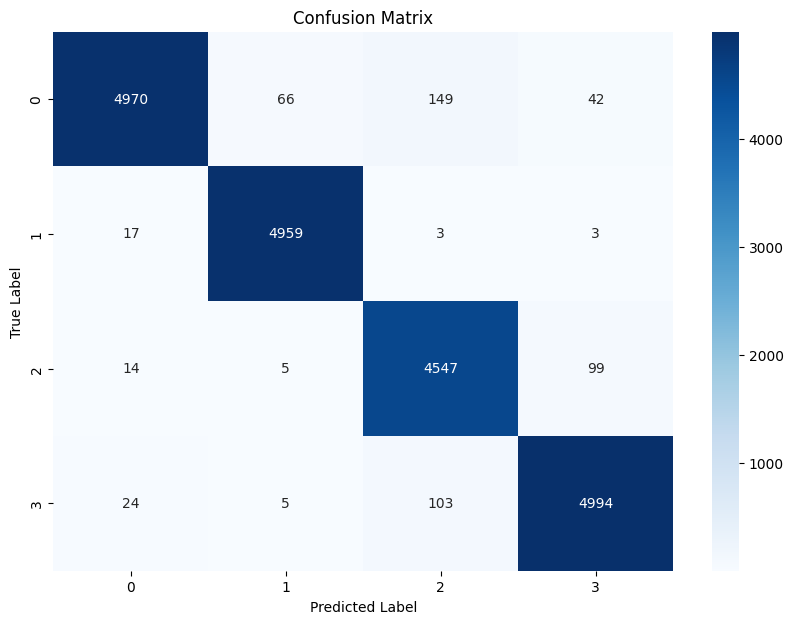

test Loss: 0.4971, Accuracy: 0.8425
Accuracy: 0.8425
Precision: 0.8465232262487739
Recall: 0.8425
F1 Score: 0.8430191095062592


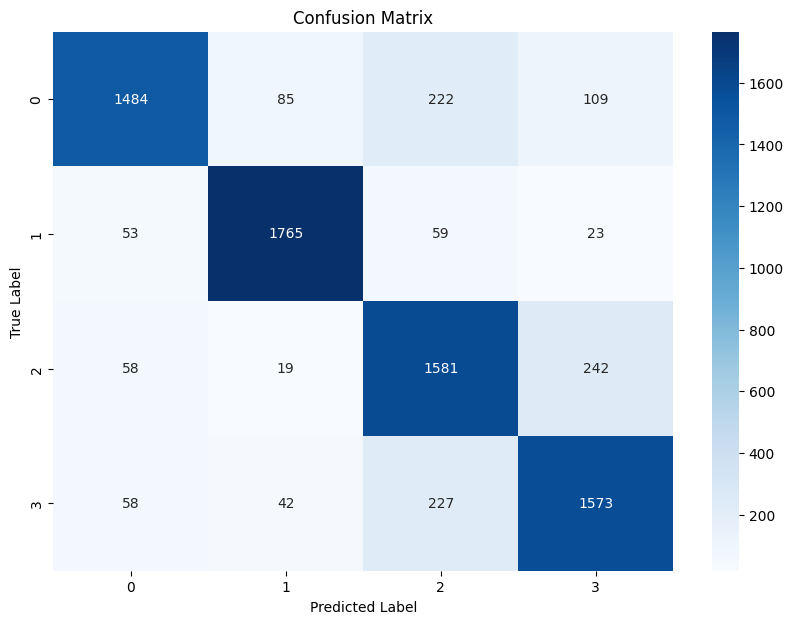

In [26]:
train_classifier(classifier1, train_dataloader, optimizer1, criterion1, device, epochs=3)
print(classifier1.weights)
test_model(classifier1, train_dataloader, criterion1,"train","frozen_weights")
test_model(classifier1, test_dataloader, criterion1,"test","frozen_weights")

In [27]:
EMBEDDING_DIM=150
VOCAB_SIZE = vocab_size 
BATCH_SIZE=32
num_classes=4
classifier2 = scoreClassifier(VOCAB_SIZE, EMBEDDING_DIM, forward_embeddings,backward_embeddings,
                 forward_model.lstm1, forward_model.lstm2, backward_model.lstm1, backward_model.lstm1, num_classes,requires_grad=True)

print(classifier2)
classifier2.to(device)
#Initializing optimizer
optimizer2 = optim.Adam(classifier2.parameters(), lr=0.001)
#Initializing loss function
criterion2 = nn.CrossEntropyLoss()


scoreClassifier(
  (fw_embeddings): Embedding(15302, 150, padding_idx=0)
  (bw_embeddings): Embedding(15302, 150, padding_idx=0)
  (forward_lstm1): LSTM(150, 150, batch_first=True)
  (forward_lstm2): LSTM(150, 150, batch_first=True)
  (backward_lstm1): LSTM(150, 150, batch_first=True)
  (backward_lstm2): LSTM(150, 150, batch_first=True)
  (rnn): LSTM(300, 150, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=150, out_features=75, bias=True)
  (linear_out): Linear(in_features=75, out_features=4, bias=True)
)


Epoch: 0


Training:  17%|█▋        | 108/625 [00:01<00:08, 59.28it/s]

Iteration: 100, Train Loss: 0.6961676478385925


Training:  34%|███▎      | 210/625 [00:03<00:06, 59.34it/s]

Iteration: 200, Train Loss: 0.5627806782722473


Training:  49%|████▉     | 306/625 [00:05<00:05, 58.90it/s]

Iteration: 300, Train Loss: 0.44548219442367554


Training:  65%|██████▌   | 408/625 [00:06<00:03, 59.05it/s]

Iteration: 400, Train Loss: 0.49110037088394165


Training:  82%|████████▏ | 510/625 [00:08<00:01, 59.26it/s]

Iteration: 500, Train Loss: 0.3416181206703186


Training:  97%|█████████▋| 606/625 [00:10<00:00, 58.90it/s]

Iteration: 600, Train Loss: 0.266828715801239


Training: 100%|██████████| 625/625 [00:10<00:00, 59.04it/s]


Epoch: 1


Training:  17%|█▋        | 108/625 [00:01<00:08, 59.27it/s]

Iteration: 100, Train Loss: 0.04362715035676956


Training:  34%|███▎      | 210/625 [00:03<00:06, 59.42it/s]

Iteration: 200, Train Loss: 0.32138335704803467


Training:  49%|████▉     | 306/625 [00:05<00:05, 59.29it/s]

Iteration: 300, Train Loss: 0.16591128706932068


Training:  65%|██████▌   | 408/625 [00:06<00:03, 59.35it/s]

Iteration: 400, Train Loss: 0.3264695405960083


Training:  82%|████████▏ | 510/625 [00:08<00:01, 59.43it/s]

Iteration: 500, Train Loss: 0.21434026956558228


Training:  97%|█████████▋| 606/625 [00:10<00:00, 59.41it/s]

Iteration: 600, Train Loss: 0.13203103840351105


Training: 100%|██████████| 625/625 [00:10<00:00, 59.34it/s]


Epoch: 2


Training:  17%|█▋        | 109/625 [00:01<00:08, 59.12it/s]

Iteration: 100, Train Loss: 0.03616350516676903


Training:  34%|███▍      | 211/625 [00:03<00:06, 59.40it/s]

Iteration: 200, Train Loss: 0.025392409414052963


Training:  49%|████▉     | 307/625 [00:05<00:05, 58.61it/s]

Iteration: 300, Train Loss: 0.13619662821292877


Training:  65%|██████▌   | 409/625 [00:06<00:03, 57.93it/s]

Iteration: 400, Train Loss: 0.046640895307064056


Training:  82%|████████▏ | 511/625 [00:08<00:01, 59.16it/s]

Iteration: 500, Train Loss: 0.07344377785921097


Training:  97%|█████████▋| 607/625 [00:10<00:00, 59.23it/s]

Iteration: 600, Train Loss: 0.09344416856765747


Training: 100%|██████████| 625/625 [00:10<00:00, 59.09it/s]


Parameter containing:
tensor([0.2465, 0.3400, 0.5102], device='cuda:0', requires_grad=True)
train Loss: 0.0748, Accuracy: 0.9806
Accuracy: 0.98055
Precision: 0.9806313767858823
Recall: 0.98055
F1 Score: 0.9805672255565027


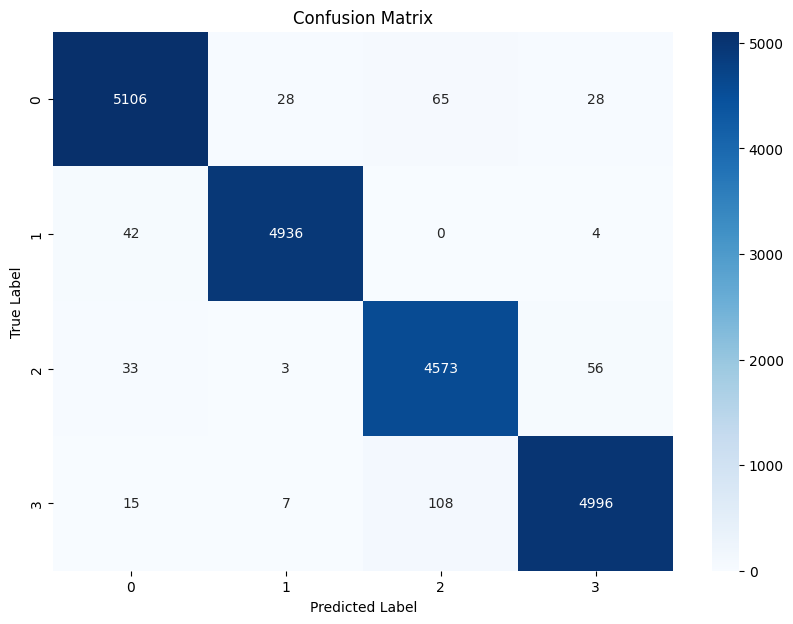

test Loss: 0.5069, Accuracy: 0.8433
Accuracy: 0.8432894736842105
Precision: 0.8437262172000559
Recall: 0.8432894736842105
F1 Score: 0.8434486642651126


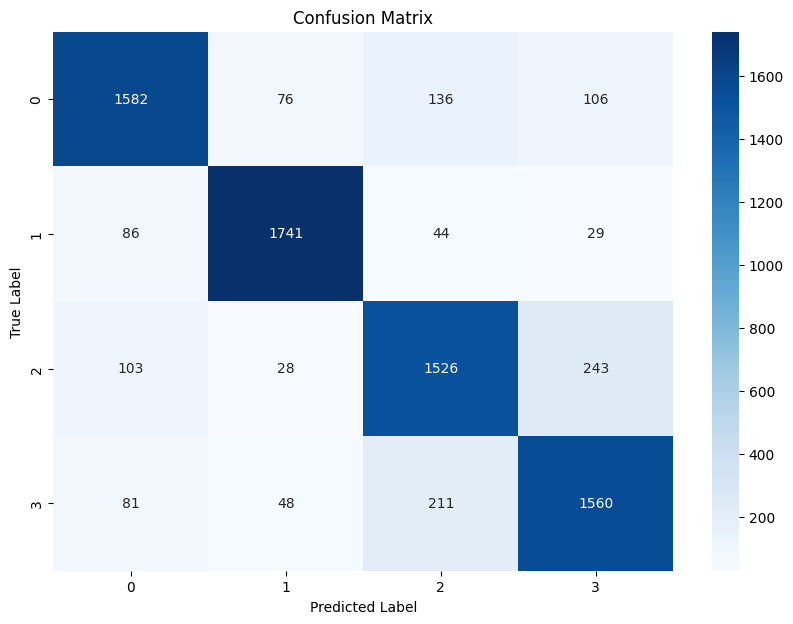

In [28]:
train_classifier(classifier2, train_dataloader, optimizer2, criterion2, device, epochs=3)
print(classifier2.weights)
test_model(classifier2, train_dataloader, criterion2,"train","unfrozen_weights")
test_model(classifier2, test_dataloader, criterion2,"test","unfrozen_weights")

In [29]:
torch.save(classifier1.state_dict(), '/kaggle/working/classifier1_frozen_weigths.pt')
torch.save(classifier2.state_dict(), '/kaggle/working/classifier2_unfrozen_weights.pt')

In [36]:
class scoreClassifierWithLinearFunction(nn.Module):
    def __init__(self, vocab_size, embedding_dim, fw_embeddings, bw_embeddings,
                 forward_lstm1, forward_lstm2, backward_lstm1, backward_lstm2, num_classes, requires_grad=True):
        super(scoreClassifierWithLinearFunction, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.fw_embeddings = nn.Embedding.from_pretrained(torch.tensor(fw_embeddings, dtype=torch.float).to(device), padding_idx=0)
        self.fw_embeddings.weight.requires_grad = False 

        self.bw_embeddings = nn.Embedding.from_pretrained(torch.tensor(bw_embeddings, dtype=torch.float).to(device), padding_idx=0)
        self.bw_embeddings.weight.requires_grad = True

#         self.weights = nn.Parameter(torch.tensor([0.33, 0.33, 0.33], dtype=torch.float).to(device), requires_grad=requires_grad)
        self.forward_lstm1 = forward_lstm1
        self.forward_lstm2 = forward_lstm2
        self.backward_lstm1 = backward_lstm1
        self.backward_lstm2 = backward_lstm2
        self.linear_function = nn.Linear(3*2*embedding_dim,2*embedding_dim).to(device)
        self.rnn = nn.LSTM(input_size=2 * embedding_dim, hidden_size=embedding_dim,
                           num_layers=2, batch_first=True, bidirectional=True).to(device)
        self.linear1 = nn.Linear(2*embedding_dim, embedding_dim//2).to(device)
        self.linear_out = nn.Linear(embedding_dim//2, num_classes).to(device)  
#         self.linear1 = nn.Linear(2 * embedding_dim, embedding_dim).to(device)
#         self.linear_out = nn.Linear(embedding_dim, num_classes).to(device)

    def forward(self, forward, backward):
        fw_embed = self.fw_embeddings(forward)
        bw_embed = self.bw_embeddings(backward)

        fw_lstm1, _ = self.forward_lstm1(fw_embed)
        fw_lstm2, _ = self.forward_lstm2(fw_lstm1)
        bw_lstm1, _ = self.backward_lstm1(bw_embed)
        bw_lstm2, _ = self.backward_lstm2(bw_lstm1)

        embed = torch.cat((fw_embed, bw_embed), dim=2)
        lstm1 = torch.cat((fw_lstm1, bw_lstm1), dim=2)
        lstm2 = torch.cat((fw_lstm2, bw_lstm2), dim=2)
        elmo_out = self.linear_function(torch.cat((embed,lstm1,lstm2),dim=2))
        elmo_max = torch.max(elmo_out, dim=1)[0]
        output,_ = self.rnn(elmo_max)
        output = self.linear1(output)
        output = self.linear_out(output)
        return output

In [37]:
EMBEDDING_DIM=150
VOCAB_SIZE = vocab_size 
BATCH_SIZE=32
num_classes=4
classifier3 = scoreClassifierWithLinearFunction(VOCAB_SIZE, EMBEDDING_DIM, forward_embeddings,backward_embeddings,
                 forward_model.lstm1, forward_model.lstm2, backward_model.lstm1, backward_model.lstm1, num_classes)

print(classifier3)
classifier3.to(device)
#Initializing optimizer
optimizer3 = optim.Adam(classifier3.parameters(), lr=0.001)
#Initializing loss function
criterion3 = nn.CrossEntropyLoss()


scoreClassifierWithLinearFunction(
  (fw_embeddings): Embedding(15302, 150, padding_idx=0)
  (bw_embeddings): Embedding(15302, 150, padding_idx=0)
  (forward_lstm1): LSTM(150, 150, batch_first=True)
  (forward_lstm2): LSTM(150, 150, batch_first=True)
  (backward_lstm1): LSTM(150, 150, batch_first=True)
  (backward_lstm2): LSTM(150, 150, batch_first=True)
  (linear_function): Linear(in_features=900, out_features=300, bias=True)
  (rnn): LSTM(300, 150, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=75, bias=True)
  (linear_out): Linear(in_features=75, out_features=4, bias=True)
)


Epoch: 0


Training:  18%|█▊        | 110/625 [00:02<00:09, 52.43it/s]

Iteration: 100, Train Loss: 0.7903423309326172


Training:  33%|███▎      | 206/625 [00:03<00:07, 53.01it/s]

Iteration: 200, Train Loss: 0.4047752022743225


Training:  49%|████▉     | 308/625 [00:05<00:05, 52.93it/s]

Iteration: 300, Train Loss: 0.2708066403865814


Training:  66%|██████▌   | 410/625 [00:07<00:04, 52.79it/s]

Iteration: 400, Train Loss: 0.6941652894020081


Training:  81%|████████  | 506/625 [00:09<00:02, 52.63it/s]

Iteration: 500, Train Loss: 0.6189544200897217


Training:  97%|█████████▋| 608/625 [00:11<00:00, 52.24it/s]

Iteration: 600, Train Loss: 0.2870877981185913


Training: 100%|██████████| 625/625 [00:11<00:00, 52.38it/s]


Epoch: 1


Training:  17%|█▋        | 108/625 [00:02<00:10, 51.42it/s]

Iteration: 100, Train Loss: 0.4748884439468384


Training:  33%|███▎      | 204/625 [00:03<00:08, 50.91it/s]

Iteration: 200, Train Loss: 0.09004583954811096


Training:  49%|████▉     | 306/625 [00:05<00:06, 51.94it/s]

Iteration: 300, Train Loss: 0.39929088950157166


Training:  65%|██████▌   | 408/625 [00:07<00:04, 52.45it/s]

Iteration: 400, Train Loss: 0.26339125633239746


Training:  82%|████████▏ | 510/625 [00:09<00:02, 52.10it/s]

Iteration: 500, Train Loss: 0.2943571209907532


Training:  97%|█████████▋| 606/625 [00:11<00:00, 51.94it/s]

Iteration: 600, Train Loss: 0.2768559455871582


Training: 100%|██████████| 625/625 [00:11<00:00, 52.11it/s]


Epoch: 2


Training:  17%|█▋        | 108/625 [00:02<00:09, 51.72it/s]

Iteration: 100, Train Loss: 0.02423746883869171


Training:  34%|███▎      | 210/625 [00:04<00:07, 52.12it/s]

Iteration: 200, Train Loss: 0.19437262415885925


Training:  49%|████▉     | 306/625 [00:05<00:06, 51.70it/s]

Iteration: 300, Train Loss: 0.13038545846939087


Training:  65%|██████▌   | 408/625 [00:07<00:04, 51.77it/s]

Iteration: 400, Train Loss: 0.23040252923965454


Training:  82%|████████▏ | 510/625 [00:09<00:02, 52.06it/s]

Iteration: 500, Train Loss: 0.1442566215991974


Training:  97%|█████████▋| 606/625 [00:11<00:00, 51.62it/s]

Iteration: 600, Train Loss: 0.24805408716201782


Training: 100%|██████████| 625/625 [00:12<00:00, 51.75it/s]


Epoch: 3


Training:  17%|█▋        | 108/625 [00:02<00:09, 51.96it/s]

Iteration: 100, Train Loss: 0.06354823708534241


Training:  34%|███▎      | 210/625 [00:04<00:07, 51.90it/s]

Iteration: 200, Train Loss: 0.09291385114192963


Training:  49%|████▉     | 306/625 [00:05<00:06, 51.74it/s]

Iteration: 300, Train Loss: 0.07499872148036957


Training:  65%|██████▌   | 408/625 [00:07<00:04, 51.77it/s]

Iteration: 400, Train Loss: 0.021208293735980988


Training:  82%|████████▏ | 510/625 [00:09<00:02, 51.82it/s]

Iteration: 500, Train Loss: 0.06625169515609741


Training:  97%|█████████▋| 606/625 [00:11<00:00, 52.00it/s]

Iteration: 600, Train Loss: 0.3371095657348633


Training: 100%|██████████| 625/625 [00:12<00:00, 51.87it/s]


Epoch: 4


Training:  17%|█▋        | 108/625 [00:02<00:09, 52.11it/s]

Iteration: 100, Train Loss: 0.07253991067409515


Training:  34%|███▎      | 210/625 [00:04<00:07, 52.18it/s]

Iteration: 200, Train Loss: 0.09266281872987747


Training:  49%|████▉     | 306/625 [00:05<00:06, 51.99it/s]

Iteration: 300, Train Loss: 0.17600814998149872


Training:  65%|██████▌   | 408/625 [00:07<00:04, 52.23it/s]

Iteration: 400, Train Loss: 0.03938949480652809


Training:  82%|████████▏ | 510/625 [00:09<00:02, 52.34it/s]

Iteration: 500, Train Loss: 0.024411221966147423


Training:  97%|█████████▋| 606/625 [00:11<00:00, 51.36it/s]

Iteration: 600, Train Loss: 0.0279887393116951


Training: 100%|██████████| 625/625 [00:12<00:00, 51.99it/s]


train Loss: 0.0835, Accuracy: 0.9792
Accuracy: 0.9792
Precision: 0.9795081860282755
Recall: 0.9792
F1 Score: 0.979240369576893


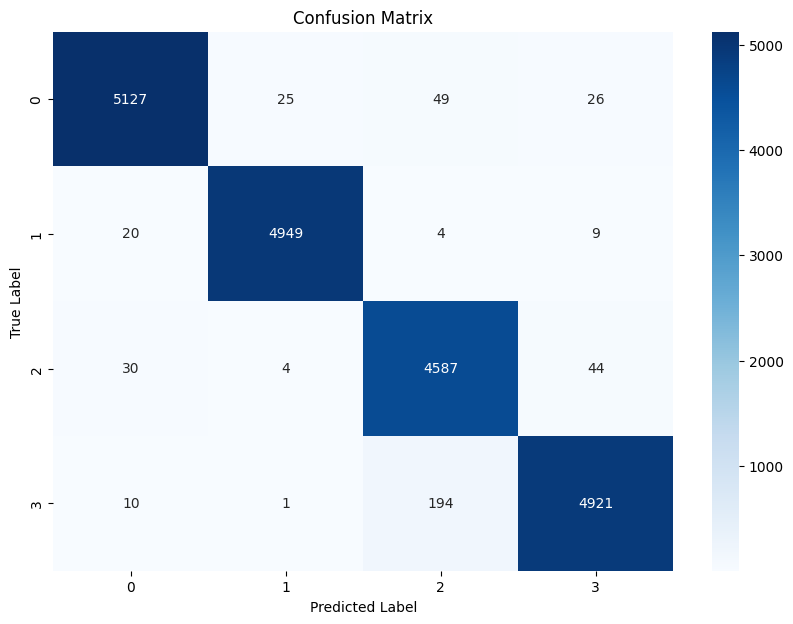

test Loss: 0.5824, Accuracy: 0.8250
Accuracy: 0.825
Precision: 0.8313844732618452
Recall: 0.825
F1 Score: 0.8268247235005447


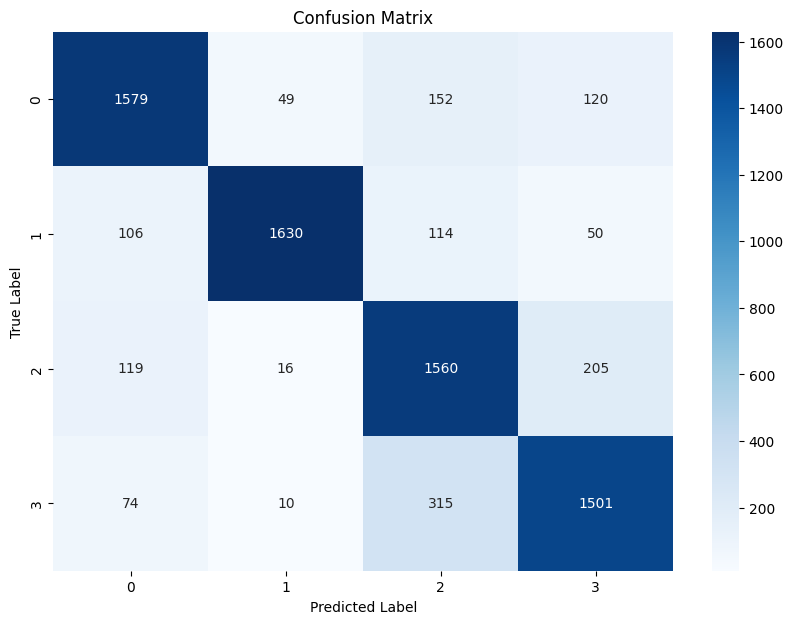

In [38]:
train_classifier(classifier3, train_dataloader, optimizer3, criterion3, device, epochs=5)
test_model(classifier3, train_dataloader, criterion3,"train","Linear_function")
test_model(classifier3, test_dataloader, criterion3,"test","Linear_function")